In [1]:
# FIXME  : 以下の関数は定義されたファイルの形式に依存するので、utilsに記載できない。
def is_env_notebook():
    """Determine wheather is the environment Jupyter Notebook"""
    if 'get_ipython' not in globals():
        # Python shell
        return False
    env_name = get_ipython().__class__.__name__
    if env_name == 'TerminalInteractiveShell':
        # IPython shell
        return False
    # Jupyter Notebook
    return True

In [2]:
from pathlib import Path
from typing import Callable, List
import os

import cv2
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib.pyplot as plt
from IPython.core.debugger import Pdb


In [3]:
ON_KAGGLE: bool = 'KAGGLE_WORKING_DIR' in os.environ
    
if ON_KAGGLE:
    from .transforms import tensor_transform
    from .utils import ON_KAGGLE
else:
    from transforms import tensor_transform,train_transform
    from utils import ON_KAGGLE


In [4]:
N_CLASSES = 5
DATA_ROOT = Path('../input/aptos2019-blindness-detection') #if ON_KAGGLE else './data')
EXTERNAL_ROOT = Path("../input/diabetic-retinopathy-resized") # 外部データ

In [5]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    

In [6]:
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    # https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping
    
   # img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    
    return img 

In [7]:
# 外部データもTrainDatasetで読み込める。
# TODO : *jpegデータに対応できるようにする。
# 回帰用のオプションを作成


class TrainDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame,
                 image_transform: Callable, debug: bool = True,regression=False):
        super().__init__()
        self._root = root
        self._df = df
        self._image_transform = image_transform
        self._debug = debug
        self.regression = regression

    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx: int):
        item = self._df.iloc[idx]
        #print(item)
        #print(self._root)
        image = load_transform_image(
            item, self._root, self._image_transform, debug=self._debug)
        
    #    for cls in item.attribute_ids.split():
    #        target[int(cls)] = 1
        cls = item.diagnosis
        
      #  Pdb().set_trace()
        
        if self.regression:
            target = torch.tensor(cls)
          #  target[0] = cls
        else:
            target = torch.zeros(N_CLASSES)
            target[int(cls)] = 1
            
        return image, target

class TTADataset:
    def __init__(self, root: Path, df: pd.DataFrame,
                 image_transform: Callable, tta: int,regression=False):
        self._root = root
        self._df = df
        self._image_transform = image_transform
        self._tta = tta

    def __len__(self):
        return len(self._df) * self._tta

    def __getitem__(self, idx):
        item = self._df.iloc[idx % len(self._df)]
        image = load_transform_image(item, self._root, self._image_transform)
        
        ## テスト用のローダーなので、item.id_codeを出力してもOK
        return image, item.id_code

def load_transform_image(
        item, root: Path, image_transform: Callable, debug: bool = False,albumentation=True):
    image = load_image(item, root)
        
    if albumentation:
        image = np.array(image)
        data = {"image":image}
        image = image_transform(**data)
        image = image["image"]
        
        # albumentationした後もdebug=Trueの際に、png画像を保存できるようにする
    else:
        # pytorch 標準の場合
        image = image_transform(image)
        if debug:
            image.save('_debug.png')

 #   Pdb().set_trace()
    
    return tensor_transform(image)


def get_ids(root: Path) -> List[str]:
    return sorted({p.name.split('_')[0] for p in root.glob('*.png')})

def make_symlink_old_dataset(srt:Path,dst:Path):
    # TODO : 作成中
    
    return 0


In [8]:
# TODO : 外部データの用の読み込みオプションでつける。*jpegなだけ。

def load_image(item, root: Path,img_size:int=600,circle:bool=True,sigmaX:int=10) -> Image.Image:
    IMG_SIZE = img_size
    # 本コンペのデータと過去のデータでファイル形式が異なるので読み込み方法を修正
    # TODO : png, jpegの両方を読み込めるようにする
    image = cv2.imread(str(root / f'{item.id_code}.png'))    
   # Pdb().set_trace()
            
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE),interpolation = cv2.INTER_CUBIC)
    
    if circle:
        image = circle_crop(image,sigmaX)
    else:
        # circle ではないcrop
        # https://www.kaggle.com/chanhu/eye-inference-num-class-1-ver3
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
      #  image = transforms.ToPILImage()(image)
    
 #   print(image.shape)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE),interpolation = cv2.INTER_CUBIC)

    return Image.fromarray(image)

In [11]:
# 過去コンペのデータセットを読み込めるようにする
# 1. fold.csvに結合
# 2. シンボリックリンクの作成
# 3. jpegファイルを読み込めるようにする。

def external_data_symlink():
    
    pass
    

In [12]:
if __name__ == "__main__":
    # load_imageの実行テスト
    import pandas as pd
    import time
#    IMG_SIZE = 224
    N = 100
    
    start = time.time()
    root = DATA_ROOT / "train_images"
    df = pd.read_csv(DATA_ROOT / 'train.csv')
    for i in np.arange(N):
        item = df.iloc[i]
        #item, root: Path, image_transform: Callable, debug: bool = False,albumentation=True):
        image = load_transform_image(item,root,train_transform)
        
    end = time.time()
    elapsed_time = end - start
    
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:10.362261533737183[sec]


In [13]:
# 1. load_image関数でIMG_SIZEを指定しなかった場合、N=100の処理に、48sかかる
# 2. load_image関数でIMG_SIZE=100の場合、N=100の処理に、17sかかる
# 3. load_image関数でIMG_SIZE=600の場合、N=100の処理に、26sかかる

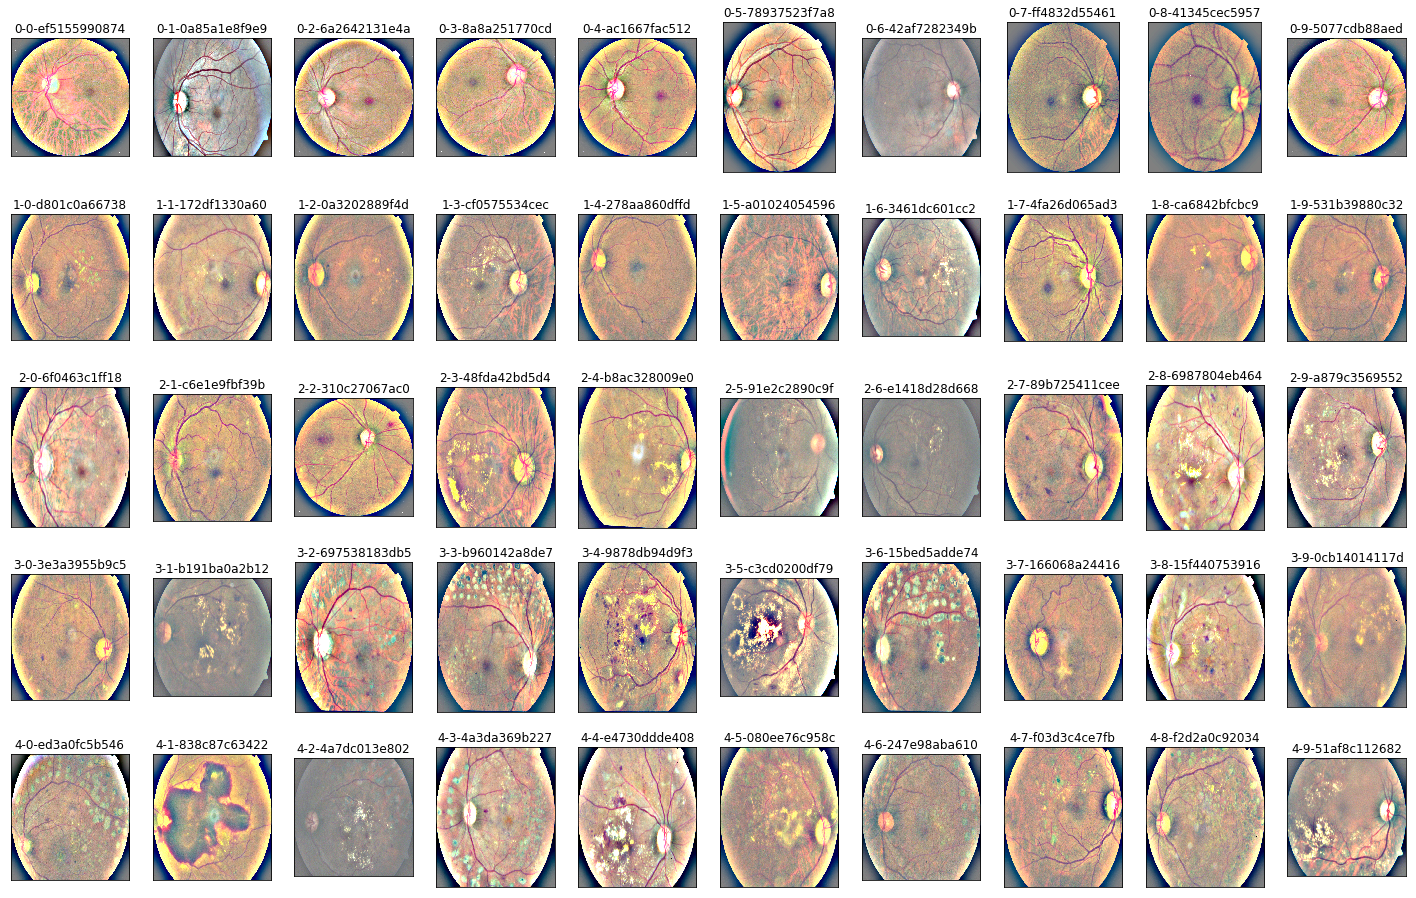

In [20]:
if __name__ == "__main__":
        # imageの可視化
    # circle cropなし
    NUM_SAMP=10
    SEED = 42
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(np.unique(df.diagnosis)):
        df_class_id = df.loc[df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED)
        for i, idx in enumerate(np.arange(NUM_SAMP)):
#            Pdb().set_trace()
            item = df_class_id.iloc[idx]
            ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
         #   path=f"../input/aptos2019-blindness-detection/train_images/{['id_code']}.png"
           # image = load_ben_color(path,sigmaX=30)
          #  Pdb().set_trace()
            image = load_image(item,root,img_size=600,circle=False,sigmaX=30)
            #image = load_transform_image()
          #  image = load_transform_image(item,root,train_transform)
          #  Pdb().set_trace()
            plt.imshow(image)
            ax.set_title('%d-%d-%s' % (class_id, idx, item.id_code))
        

In [12]:
if __name__ == "__main__":
    from albumentations import (Rotate,
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, 
    Compose,Resize,RandomScale,RandomGamma,RandomCrop,CenterCrop,RandomSizedCrop
)
    
    #INPUT_IMG_SIZE = 600
    IMG_SIZE = 288
    MIN_MAX_HEIGHT = [IMG_SIZE/2,IMG_SIZE]
    
    vis_transform = Compose([
                 Resize(width=IMG_SIZE,height=IMG_SIZE),
              #  RandomCrop(288),
               # HorizontalFlip(),
               # Rotate((-120, 120)),
               # RandomBrightnessContrast(),
               # HueSaturationValue(),
               # RandomScale(),
               # RandomGamma(),
                #RandomCrop(int(IMG_SIZE * 0.8),int(IMG_SIZE * 0.8)),
                RandomSizedCrop(min_max_height = MIN_MAX_HEIGHT,
                               width = IMG_SIZE,
                               height = IMG_SIZE)
          #      CenterCrop(IMG_SIZE,IMG_SIZE)
            ])

    vis_transform = train_transform

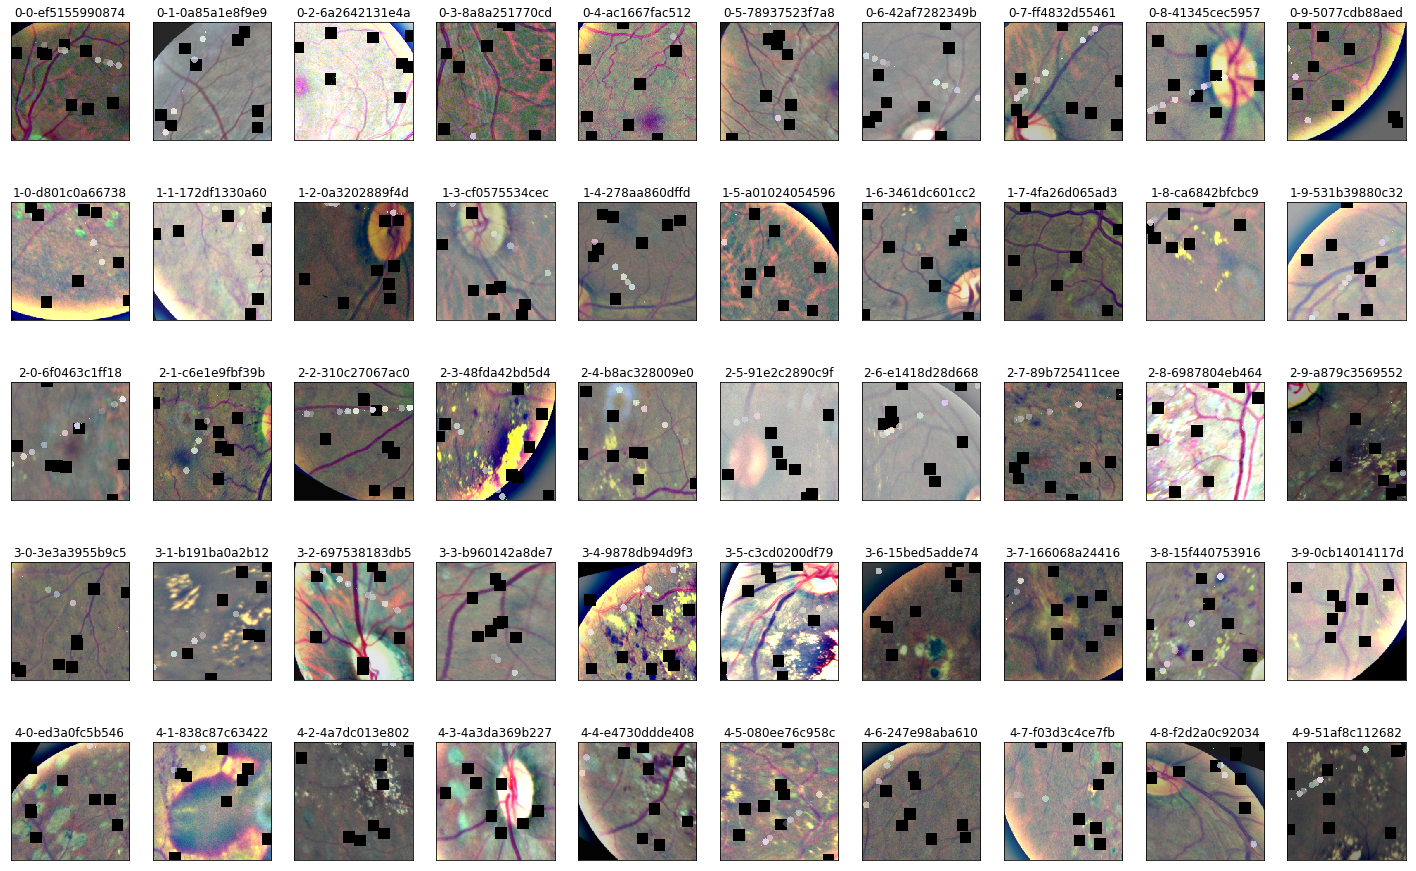

In [13]:
if __name__ == "__main__":
        # imageの可視化
    # circle cropあり
    NUM_SAMP=10
    SEED = 42
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(np.unique(df.diagnosis)):
        df_class_id = df.loc[df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED)
        for i, idx in enumerate(np.arange(NUM_SAMP)):
#            Pdb().set_trace()
            item = df_class_id.iloc[idx]
            ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
         #   path=f"../input/aptos2019-blindness-detection/train_images/{['id_code']}.png"
           # image = load_ben_color(path,sigmaX=30)
           # Pdb().set_trace()
            image = load_image(item,root,img_size=600,circle=True,sigmaX=20)
            # Data Augmentation部分
            image = np.array(image)
          #  Pdb().set_trace()
          #  print(image.shape)
            
            data = {"image":image}
            image = vis_transform(**data)
            image = image["image"]

            # FIXME : transformした画像を表示したい。
            #image = load_transform_image(item,root,train_transform)
            #img = Image.fromarray(np.uint8(image.numpy()))
            plt.imshow(image)
            ax.set_title('%d-%d-%s' % (class_id, idx, item.id_code))

1. 過去のコンペのデータデータセットの加工

In [25]:
if __name__ == "__main__":
    # load_imageの実行テスト
    import pandas as pd
    import time
    from IPython.core.debugger import Pdb
#    IMG_SIZE = 224

    N = 100
    
    start = time.time()
  #  df = pd.read_csv(DATA_ROOT / 'train.csv')
    DATA_ROOT_OLD = Path('../input/diabetic-retinopathy-resized')
    df_old = pd.read_csv(DATA_ROOT_OLD/'trainLabels.csv')\
               .rename(columns={'image':'id_code',
                               "level":"diagnosis"})
#    Pdb().set_trace()
    root = DATA_ROOT_OLD / "resized_train/resized_train"
    for i in np.arange(N):
        item = df_old.iloc[i]   
        image = load_image(item,root)
        
    end = time.time()
    elapsed_time = end - start
    
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:2.320298194885254[sec]


In [18]:
if __name__ == "__main__":
        # imageの可視化
    # circle cropあり
    NUM_SAMP=10
    SEED = 42
    fig = plt.figure(figsize=(25, 16))
    for class_id in sorted(np.unique(df_old.diagnosis)):
        df_class_id = df_old.loc[df_old['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED)
        for i, idx in enumerate(np.arange(NUM_SAMP)):
         #   Pdb().set_trace()
            item = df_class_id.iloc[idx]
            ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
         #   path=f"../input/aptos2019-blindness-detection/train_images/{['id_code']}.png"
            #image = load_ben_color(path,sigmaX=30)
          #  image = load_image(item,root,img_size=600,circle=True)
          #  Pdb().set_trace()
            
            plt.imshow(image)
            ax.set_title('%d-%d-%s' % (class_id, idx, item.id_code))

NameError: name 'df_old' is not defined

<Figure size 1800x1152 with 0 Axes>

# DataLoaderがうまく機能しているか確認

In [18]:
if __name__ == "__main__":
    root = DATA_ROOT / "train_images"
    df = pd.read_csv(DATA_ROOT / 'train.csv')
    
    train_loader = TrainDataset(root,df,train_transform,debug=False,regression=True)
    
    for i,v in enumerate(train_loader):
        print(v)
        break

(tensor([[[0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138],
         [0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138],
         [0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138],
         ...,
         [0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138],
         [0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138],
         [0.3138, 0.3138, 0.3138,  ..., 0.3138, 0.3138, 0.3138]],

        [[0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503],
         [0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503],
         [0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503],
         ...,
         [0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503],
         [0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503],
         [0.4503, 0.4503, 0.4503,  ..., 0.4503, 0.4503, 0.4503]],

        [[0.6705, 0.6705, 0.6705,  ..., 0.6705, 0.6705, 0.6705],
         [0.6705, 0.6705, 0.6705,  ..., 0.6705, 0.6705, 0.6705],
         [0.6705, 0.6705, 0.6705,  ..., 0.6705, 0.6705, 0

# Data Augmentationの結果を可視化

In [9]:
if __name__ == "__main__":
    root = DATA_ROOT / "train_images"
    df = pd.read_csv(DATA_ROOT / 'train.csv')
    
    item = df.iloc[1]
    
    image = load_image(item,root)
    image = np.array(image)
    data = {"image":image}
    image = train_transform(**data)
    image = image["image"]